In [2]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

In [9]:
def neg_likelihood(dist, samples, idx=0):
    likelihood = dist.gm.marg_pdf(samples,idx)
    log_likelihood = torch.log(likelihood)
    return -torch.sum(log_likelihood)

### Test 1
``` a = gm([1.], [_mean], [1.]); ```


Genero sample da $\mathcal{N}(10,1)$

In [32]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim1.soga')
cfg = produce_cfg(compiledFile)

In [33]:
pars = {'mean':5.}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [34]:
output_dist = start_SOGA(cfg, params_dict)

In [35]:
output_dist

Dist<['a'],pi: [tensor(1.)]  mu: [tensor([5.], grad_fn=<CopySlices>)] sigma: [tensor([[1.]])]>

In [36]:
sampling_mean = torch.tensor(10.)
sampling_std = torch.tensor(1.)
samples = distributions.Normal(sampling_mean, sampling_std).sample((100,1))

In [37]:
import torch

# Define the optimizer with init_mean as the parameter

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.05)

for i in range(500):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    #current_dist = compute_posterior(init_mean)
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 50 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


mean: 5.050000190734863 loss: 1416.3583984375
mean: 7.357194423675537 loss: 518.194091796875
mean: 8.909857749938965 loss: 214.9001922607422
mean: 9.679874420166016 loss: 155.70977783203125
mean: 9.954289436340332 loss: 149.4296875
mean: 10.022300720214844 loss: 149.09446716308594
mean: 10.03339672088623 loss: 149.08651733398438
mean: 10.034412384033203 loss: 149.08645629882812
mean: 10.034433364868164 loss: 149.08645629882812
mean: 10.034433364868164 loss: 149.08645629882812


In [38]:
sampling_dist = Dist(['x'], GaussianMix([torch.tensor(1.)], [torch.tensor([sampling_mean.item()])], [torch.tensor([[sampling_std.item()]])]))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples))

Likelihood with respect to the sampling distribution:  tensor(149.1457)
Likelihood in the optimized distribution:  tensor(149.0865, grad_fn=<NegBackward0>)


### Test 2

``` a = gm([1.], [10.], [_std]);  ```

In [39]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim2.soga')
cfg = produce_cfg(compiledFile)

In [49]:
pars = {'std':2.}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [50]:
output_dist = start_SOGA(cfg, params_dict)

In [51]:
output_dist

Dist<['a'],pi: [tensor(1.)]  mu: [tensor([10.])] sigma: [tensor([[4.]], grad_fn=<CopySlices>)]>

In [52]:
sampling_mean = torch.tensor(10.)
sampling_std = torch.tensor(1.)
samples = distributions.Normal(sampling_mean, sampling_std).sample((1000,1))
print('samples std', torch.std(samples))

samples std tensor(1.0489)


In [53]:
import torch

# Define the optimizer with init_mean as the parameter

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.01)

for i in range(500):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    #current_dist = compute_posterior(init_mean)
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 50 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


std: 1.9900000095367432 loss: 1749.518798828125
std: 1.491482138633728 loss: 1569.150390625
std: 1.0948957204818726 loss: 1468.535400390625
std: 1.0458248853683472 loss: 1466.3587646484375
std: 1.0485780239105225 loss: 1466.35009765625
std: 1.0485713481903076 loss: 1466.35009765625
std: 1.0485520362854004 loss: 1466.35009765625
std: 1.0485539436340332 loss: 1466.35009765625
std: 1.0485539436340332 loss: 1466.35009765625
std: 1.0485539436340332 loss: 1466.35009765625


In [54]:
sampling_dist = Dist(['x'], GaussianMix([torch.tensor(1.)], [torch.tensor([sampling_mean.item()])], [torch.tensor([[sampling_std.item()**2]])]))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples))

Likelihood with respect to the sampling distribution:  tensor(1468.6707)
Likelihood in the optimized distribution:  tensor(1466.3501, grad_fn=<NegBackward0>)


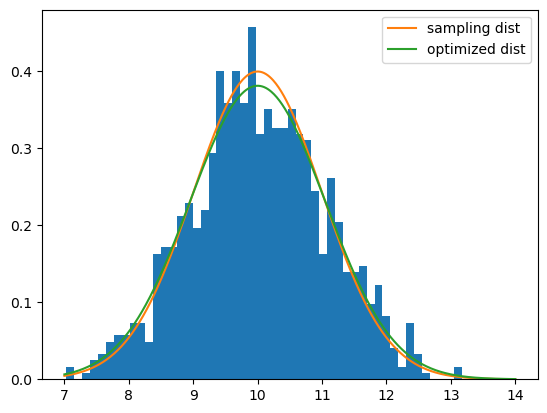

In [55]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = np.linspace(7,14,500)
y_sampling = norm(sampling_mean.item(), sampling_std.item()).pdf(x)
y_optim = norm(sampling_mean.item(), params_dict['std'].item()).pdf(x)

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()

### TEST 3

```
a = gm([1.], [1.], [1.]);
a = _par1 * a + 1.;
```

sample from the program with _par1 = 2

In [56]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

In [57]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim3.soga')
cfg = produce_cfg(compiledFile)

In [65]:
pars = {'par1':1.}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [66]:
output_dist = start_SOGA(cfg, params_dict)

In [67]:
output_dist

Dist<['a'],pi: [tensor(1.)]  mu: [tensor([1.], grad_fn=<CopySlices>)] sigma: [tensor([[1.]], grad_fn=<CopySlices>)]>

In [68]:
sampling_mean = torch.tensor(2.)
sampling_std = torch.tensor(2.)
samples = distributions.Normal(sampling_mean, sampling_std).sample((1000,1))

In [69]:
torch.var(samples)

tensor(4.2846)

In [70]:
import torch

# Define the optimizer with init_mean as the parameter

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.01)

for i in range(500):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    #current_dist = compute_posterior(init_mean)
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 50 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


par1: 1.0099999904632568 loss: 3694.81201171875
par1: 1.4097660779953003 loss: 2476.617431640625
par1: 1.621532678604126 loss: 2267.058837890625
par1: 1.755641222000122 loss: 2199.38134765625
par1: 1.8494582176208496 loss: 2171.19482421875
par1: 1.917319893836975 loss: 2158.236572265625
par1: 1.966970443725586 loss: 2152.01416015625
par1: 2.0033071041107178 loss: 2148.981689453125
par1: 2.029721260070801 loss: 2147.508056640625
par1: 2.048694372177124 loss: 2146.80322265625


In [71]:
sampling_dist = Dist(['x'], GaussianMix([torch.tensor(1.)], [torch.tensor([sampling_mean.item()])], [torch.tensor([[sampling_std.item()**2]])]))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples))

Likelihood with respect to the sampling distribution:  tensor(2149.1638)
Likelihood in the optimized distribution:  tensor(2146.4751, grad_fn=<NegBackward0>)


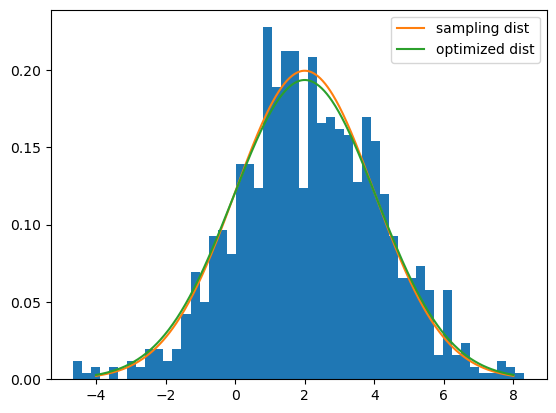

In [72]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = np.linspace(-4,8,500)
y_sampling = norm(sampling_mean.item(), sampling_std.item()).pdf(x)
y_optim = norm(sampling_mean.item(), np.sqrt(output_dist.gm.sigma[0][0,0].item())).pdf(x)

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()

### TEST 4

```
a = gm([1.], [1.], [1.]);
a = 2 * a + _par2;
```

sample from the program with _par2 = 1

In [73]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

In [74]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim4.soga')
cfg = produce_cfg(compiledFile)

In [81]:
pars = {'par2':2.}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [82]:
output_dist = start_SOGA(cfg, params_dict)

In [83]:
output_dist

Dist<['a'],pi: [tensor(1.)]  mu: [tensor([4.], grad_fn=<CopySlices>)] sigma: [tensor([[4.]])]>

In [84]:
sampling_mean = torch.tensor(3.)
sampling_std = torch.tensor(2.)
samples = distributions.Normal(sampling_mean, sampling_std).sample((1000,1))

In [85]:
torch.var(samples)

tensor(4.1070)

In [86]:
import torch

# Define the optimizer with init_mean as the parameter

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.001)

for i in range(500):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    #current_dist = compute_posterior(init_mean)
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 50 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


par2: 1.9989999532699585 loss: 2281.220703125
par2: 1.9492876529693604 loss: 2267.6298828125
par2: 1.9005916118621826 loss: 2254.913818359375
par2: 1.853035569190979 loss: 2243.068115234375
par2: 1.8066297769546509 loss: 2232.05419921875
par2: 1.7613822221755981 loss: 2221.833740234375
par2: 1.7173012495040894 loss: 2212.36962890625
par2: 1.6743957996368408 loss: 2203.625
par2: 1.6326736211776733 loss: 2195.5625
par2: 1.59214448928833 loss: 2188.14794921875


In [87]:
sampling_dist = Dist(['x'], GaussianMix([torch.tensor(1.)], [torch.tensor([sampling_mean.item()])], [torch.tensor([[sampling_std.item()**2]])]))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples))

Likelihood with respect to the sampling distribution:  tensor(2126.6912)
Likelihood in the optimized distribution:  tensor(2181.3462, grad_fn=<NegBackward0>)


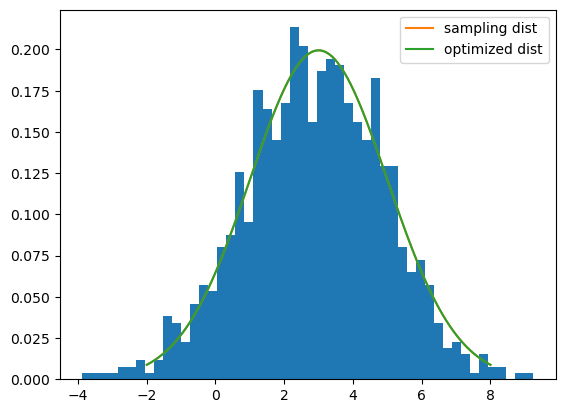

In [88]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = np.linspace(-2,8,500)
y_sampling = norm(sampling_mean.item(), sampling_std.item()).pdf(x)
y_optim = norm(sampling_mean.item(), np.sqrt(output_dist.gm.sigma[0][0,0].item())).pdf(x)

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()

### TEST 5

``` 
if gm([1.], [_mean], [1.]) < 0 {
    a = gm([1.], [-5.], [1.]);
} else {
    a = gm([1.], [5.], [1.]);
} end if;
```

sample from the program with _mean = 0

In [89]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

In [90]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim5.soga')
cfg = produce_cfg(compiledFile)

In [101]:
pars = {'mean':0.5}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [102]:
output_dist = start_SOGA(cfg, params_dict)

In [103]:
output_dist

Dist<['a'],pi: [tensor(0.3085, grad_fn=<UnbindBackward0>), tensor(0.6915, grad_fn=<UnbindBackward0>)]  mu: [tensor([-5.], grad_fn=<CopySlices>), tensor([5.], grad_fn=<CopySlices>)] sigma: [tensor([[1.]], grad_fn=<CopySlices>), tensor([[1.]], grad_fn=<CopySlices>)]>

In [104]:
sampling_pi = torch.tensor(0.5)
sampling_mean = torch.tensor(3.)
sampling_std = torch.tensor(2.)

samples = torch.zeros((500,1))
latent = distributions.Bernoulli(sampling_pi).sample(samples.shape)
for i, r in enumerate(latent):
    if r:
        samples[i] = distributions.Normal(torch.tensor(-5.), torch.tensor(1.)).sample((1,))
    else:
        samples[i] = distributions.Normal(torch.tensor(5.), torch.tensor(1.)).sample((1,))

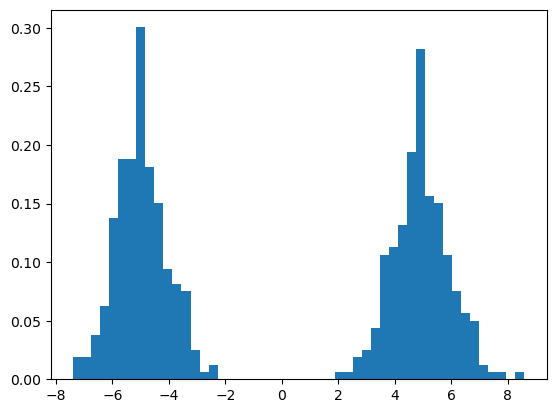

In [105]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

In [106]:
def neg_likelihood(dist, samples, idx=0):
    likelihood = dist.gm.marg_pdf(samples,idx)
    log_likelihood = torch.log(likelihood)
    return -torch.sum(log_likelihood)

In [107]:
import torch

#pars = {'mean':2.}
#
## creates torch parameters for each params declared in the dictionary
#params_dict = {}
#for key, value in pars.items():
#    params_dict[key] = torch.tensor(value, requires_grad=True)    

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.01)

for i in range(300):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 30 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


mean: 0.49000000953674316 loss: 1076.22802734375
mean: 0.21167771518230438 loss: 1043.349365234375
mean: 0.040631067007780075 loss: 1035.423828125
mean: -0.010830267332494259 loss: 1034.9571533203125
mean: -0.012350328266620636 loss: 1034.9580078125
mean: -0.009973554871976376 loss: 1034.9571533203125
mean: -0.009933455847203732 loss: 1034.95703125
mean: -0.010041352361440659 loss: 1034.9571533203125
mean: -0.010027818381786346 loss: 1034.9571533203125
mean: -0.010025854222476482 loss: 1034.957275390625


In [108]:
sampling_dist = Dist(['x'], GaussianMix([torch.tensor(0.5), torch.tensor(0.5)], [torch.tensor([-5.]), torch.tensor([5.])], [torch.tensor([[1.]]), torch.tensor([[1.]])]))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples, idx=0))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples, idx=0))

Likelihood with respect to the sampling distribution:  tensor(1034.9731)
Likelihood in the optimized distribution:  tensor(1034.9572, grad_fn=<NegBackward0>)


In [109]:
output_dist

Dist<['a'],pi: [tensor(0.5040, grad_fn=<UnbindBackward0>), tensor(0.4960, grad_fn=<UnbindBackward0>)]  mu: [tensor([-5.], grad_fn=<CopySlices>), tensor([5.], grad_fn=<CopySlices>)] sigma: [tensor([[1.]], grad_fn=<CopySlices>), tensor([[1.]], grad_fn=<CopySlices>)]>

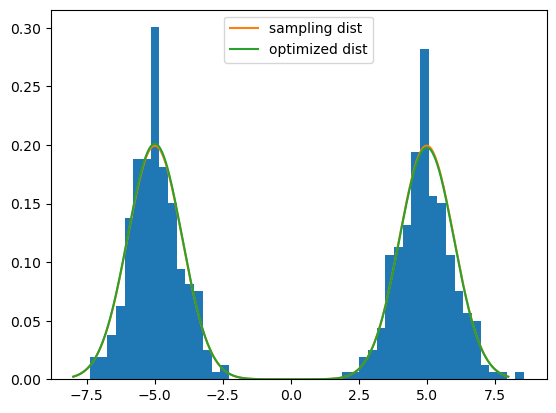

In [110]:
import matplotlib.pyplot as plt
from scipy.stats import norm


npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = torch.linspace(-8,8,500)
y_sampling = sampling_dist.gm.marg_pdf(x, 0)
y_optim = output_dist.gm.marg_pdf(x, 0).detach()

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()

### TEST 6

``` 
if gm([1.], [0.], [1.]) < _coeff {
    a = gm([1.], [-5.], [1.]);
} else {
    a = gm([1.], [5.], [1.]);
} end if;
```

sample from the program with _coeff = 0

In [111]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

In [112]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim6.soga')
cfg = produce_cfg(compiledFile)

In [113]:
pars = {'coeff':0.5}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [114]:
output_dist = start_SOGA(cfg, params_dict)

In [115]:
output_dist

Dist<['a'],pi: [tensor(0.6915, grad_fn=<UnbindBackward0>), tensor(0.3085, grad_fn=<UnbindBackward0>)]  mu: [tensor([-5.], grad_fn=<CopySlices>), tensor([5.], grad_fn=<CopySlices>)] sigma: [tensor([[1.]], grad_fn=<CopySlices>), tensor([[1.]], grad_fn=<CopySlices>)]>

In [116]:
sampling_pi = torch.tensor(0.5)
sampling_mean = torch.tensor(3.)
sampling_std = torch.tensor(2.)

samples = torch.zeros((500,1))
latent = distributions.Bernoulli(sampling_pi).sample(samples.shape)
for i, r in enumerate(latent):
    if r:
        samples[i] = distributions.Normal(torch.tensor(-5.), torch.tensor(1.)).sample((1,))
    else:
        samples[i] = distributions.Normal(torch.tensor(5.), torch.tensor(1.)).sample((1,))

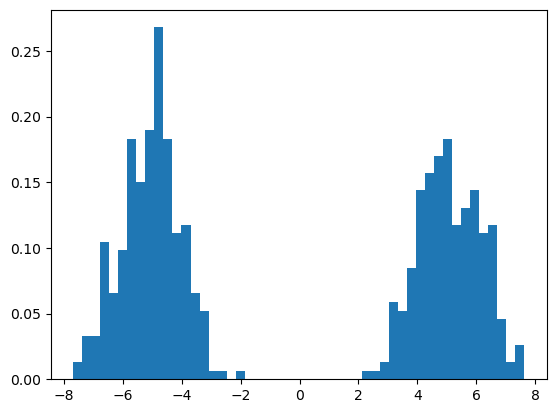

In [117]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

In [118]:
import torch

#pars = {'mean':2.}
#
## creates torch parameters for each params declared in the dictionary
#params_dict = {}
#for key, value in pars.items():
#    params_dict[key] = torch.tensor(value, requires_grad=True)    

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.01)

for i in range(300):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 30 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


coeff: 0.49000000953674316 loss: 1099.474609375
coeff: 0.2148585021495819 loss: 1071.3173828125
coeff: 0.06297897547483444 loss: 1066.1365966796875
coeff: 0.03420620784163475 loss: 1066.0389404296875
coeff: 0.039260491728782654 loss: 1066.033447265625
coeff: 0.040453020483255386 loss: 1066.0333251953125
coeff: 0.04009352624416351 loss: 1066.033203125
coeff: 0.040108732879161835 loss: 1066.033203125
coeff: 0.040119849145412445 loss: 1066.033203125
coeff: 0.04011625051498413 loss: 1066.033203125


In [119]:
sampling_dist = Dist(['x'], GaussianMix([torch.tensor(0.5), torch.tensor(0.5)], [torch.tensor([-5.]), torch.tensor([5.])], [torch.tensor([[1.]]), torch.tensor([[1.]])]))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples, idx=0))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples, idx=0))

Likelihood with respect to the sampling distribution:  tensor(1066.2893)
Likelihood in the optimized distribution:  tensor(1066.0332, grad_fn=<NegBackward0>)


In [120]:
output_dist

Dist<['a'],pi: [tensor(0.5160, grad_fn=<UnbindBackward0>), tensor(0.4840, grad_fn=<UnbindBackward0>)]  mu: [tensor([-5.], grad_fn=<CopySlices>), tensor([5.], grad_fn=<CopySlices>)] sigma: [tensor([[1.]], grad_fn=<CopySlices>), tensor([[1.]], grad_fn=<CopySlices>)]>

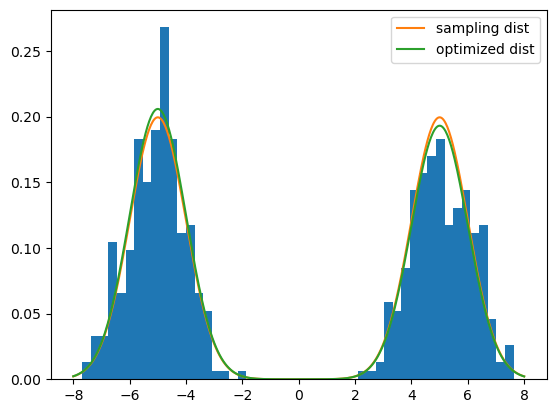

In [121]:
import matplotlib.pyplot as plt
from scipy.stats import norm


npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = torch.linspace(-8,8,500)
y_sampling = sampling_dist.gm.marg_pdf(x, 0)
y_optim = output_dist.gm.marg_pdf(x, 0).detach()

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()

### TEST 7

``` 
a = gm([1.], [_mean], [_std]); 
```

In [111]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

In [132]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim7.soga')
cfg = produce_cfg(compiledFile)

In [133]:
pars = {'mean':5., 'std':2.5}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [134]:
output_dist = start_SOGA(cfg, params_dict)

In [135]:
output_dist

Dist<['a'],pi: [tensor(1.)]  mu: [tensor([5.], grad_fn=<CopySlices>)] sigma: [tensor([[6.2500]], grad_fn=<CopySlices>)]>

In [136]:
sampling_mean = torch.tensor(10.)
sampling_std = torch.tensor(1.)
samples = distributions.Normal(sampling_mean, sampling_std).sample((1000,1))
print('samples std', torch.std(samples))

samples std tensor(1.0276)


In [137]:
import torch

# Define the optimizer with init_mean as the parameter

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.01)

for i in range(1000):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    #current_dist = compute_posterior(init_mean)
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 100 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


mean: 5.010000228881836std: 2.509999990463257 loss: 3927.216796875
mean: 5.88068151473999std: 3.2226758003234863 loss: 2964.5908203125
mean: 6.569282531738281std: 3.4557135105133057 loss: 2700.546142578125
mean: 7.199153900146484std: 3.4083430767059326 loss: 2532.11572265625
mean: 7.820949077606201std: 3.1286895275115967 loss: 2360.00634765625
mean: 8.473640441894531std: 2.609358549118042 loss: 2131.51025390625
mean: 9.204216003417969std: 1.807271957397461 loss: 1775.951416015625
mean: 9.920854568481445std: 1.03395414352417 loss: 1449.7442626953125
mean: 10.009870529174805std: 1.0270413160324097 loss: 1445.674072265625
mean: 10.009480476379395std: 1.0270953178405762 loss: 1445.6739501953125


In [138]:
sampling_dist = Dist(['x'], GaussianMix([torch.tensor(1.)], [torch.tensor([sampling_mean.item()])], [torch.tensor([[sampling_std.item()**2]])]))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples))

Likelihood with respect to the sampling distribution:  tensor(1446.4467)
Likelihood in the optimized distribution:  tensor(1445.6740, grad_fn=<NegBackward0>)


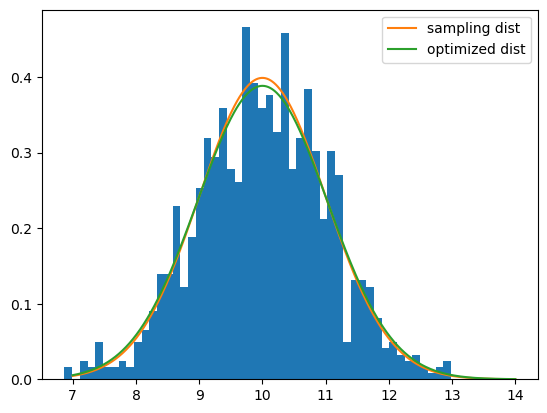

In [139]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = np.linspace(7,14,500)
y_sampling = norm(sampling_mean.item(), sampling_std.item()).pdf(x)
y_optim = norm(sampling_mean.item(), params_dict['std'].item()).pdf(x)

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()